In [1]:
## experimental re-hash of process_hazmap

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os
from IPython.display import clear_output

# display all of a df
pd.set_option("display.max_rows", None, "display.max_columns", None)

# turn warnings off (danger)
import warnings
warnings.filterwarnings('ignore')

In [3]:
## inputs
date_min = pd.to_datetime("20190501")
date_max = pd.to_datetime("20190930")

site_lat, site_lon = 53.91439, -106.06958
site_name = "waskesiu"

# set size limits for plot
disp_width = 50  # degrees
disp_height = 30  # degrees

In [4]:
## set up site 

# convert site to shapely point
polygon_geom = Point((site_lon, site_lat))
crs = {"init": "EPSG:4326"}
the_site = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
the_site = the_site.to_crs(epsg=4326)

# create the boundary box of specified size
disp_width /= 2
disp_height /= 2

lat_point_list = [
    site_lat + disp_height,
    site_lat + disp_height,
    site_lat - disp_height,
    site_lat - disp_height,
]
lon_point_list = [
    site_lon - disp_width,
    site_lon + disp_width,
    site_lon + disp_width,
    site_lon - disp_width,
]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = {"init": "EPSG:4326"}
plot_bbox = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
plot_bbox = plot_bbox.to_crs(epsg=4326)

# complicated way to assign the data a projection
#the_file.crs = {'init' :'epsg:4326'}
#the_file = the_file.to_crs(epsg=4326)
#the_file = gpd.clip(the_file, plot_bbox)
#the_file.reset_index(inplace=True, drop=True)

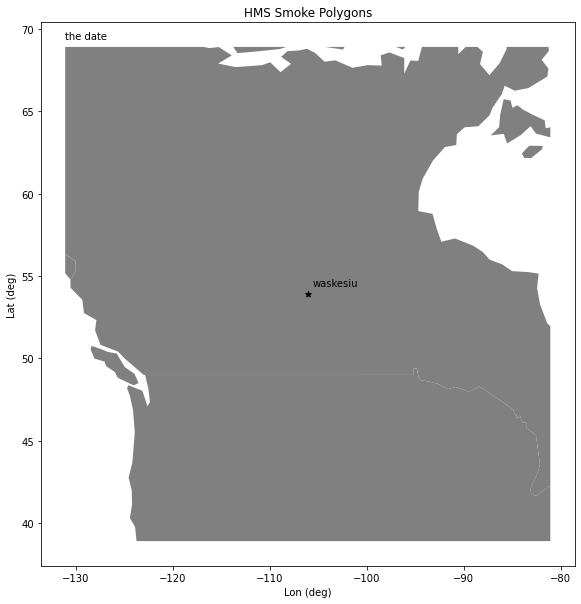

In [5]:
## set up initial plot

# get a basemap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.clip(world, plot_bbox)

# do the plot
fig, ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax, color="grey")
sitemarker = the_site.plot(ax=ax, marker="*", color="k")
ax.text(site_lon + 0.5, site_lat + 0.5, site_name)
ax.set_title(f"HMS Smoke Polygons")
ax.set_xlabel("Lon (deg)")
ax.set_ylabel("Lat (deg)")
ax.text(site_lon-25, site_lat+15.5, "the date")

plt.show()

In [6]:
## generate the list of all files we need so we can loop over them
range_dates = pd.date_range(start=date_min, end=date_max)

# initialize the empty df
smoke_df = pd.DataFrame(columns=("date", "smoke"))


def get_file(path, date):
    """
    gets the file and converts dates to pandas format
    """
    the_file = gpd.read_file(path)

    # add a density column if necessary (pre 2008 files lack them)
    if "Density" not in the_file.columns.values:
        the_file["Density"] = 1.000  # code for ambiguous smoke level

    # convert datetime format -- ##this needs to handle more alternative dt formats##
    try:
        the_file["Start"] = pd.to_datetime(the_file["Start"], format="%Y%j %H%M")
        the_file["End"] = pd.to_datetime(the_file["End"], format="%Y%j %H%M")
    except:
        the_file["Start"] = pd.to_datetime(the_file["Start"], format="%H%M")
        the_file["End"] = pd.to_datetime(the_file["End"], format="%H%M")

    return the_file


def clip_file(the_file, bbox):
    """
    assigns file a projection and clips all shapes to specd boundary box bbox
    """
    the_file.crs = {"init": "epsg:4326"}
    the_file = the_file.to_crs(epsg=4326)
    #the_file = gpd.clip(the_file, plot_bbox) # bug in clipping function needs to be sorted before animation is possible
    #the_file.reset_index(inplace=True, drop=True)
    return the_file

print(f"Analyzing Hazmap Smoke Levels at {site_name} from {date_min.year}{date_min.month}{date_min.day} to {date_max.year}{date_max.month}{date_max.day}")
for date in range_dates:
    path_to_file = f"C:/Users/Owner/Wildfire_Smoke_Mckendry/data/shapefile_smoke_polygons/smoke{date.year}/smoke{str(date)[:4]}{str(date)[5:7]}{str(date)[8:10]}.shp"
    empty_file = "empty_smokefile.shp"
    
    # get_file
    clear_output()
    try:
        file = get_file(path_to_file, date)
        print(f"Processing data from {date.year}-{date.month}-{date.day}")
    except: # if file DNE
        file = get_file(empty_file, date)
        print(f"Data missing from {date.year}-{date.month}-{date.day}")
    clip_file(file, plot_bbox)

    # loop through each hour in the file and append the dataframe (this could be made faster)
    range_hours = pd.date_range(start=date, periods=24, freq="H")
    for hour in range_hours:
        # filter by hour
        hourly_file = file[file["Start"] < hour]
        hourly_file = hourly_file[hour < hourly_file["End"]]
        
        # plotting routine goes HERE
        
        # find the intersections
        ign, locs = hourly_file.sindex.query_bulk(the_site["geometry"], predicate="intersects")
        hourly_file["intersects"] = np.isin(np.arange(0, len(hourly_file)), locs)
        hourly_file = hourly_file[hourly_file["intersects"] == True]
        
        # find the smokiest polygon in the list
        try:
            max_smoke = max(hourly_file["Density"].values)
        except ValueError: # if the list is empty
            max_smoke = 0

        # output to the dataframe
        smoke_df = smoke_df.append({"date": hour, "smoke": max_smoke}, ignore_index=True)

# save and display the result
smoke_df.to_csv(f"C:/Users/Owner/Wildfire_Smoke_Mckendry/data/out_data/hazmap_{site_name}_short.csv")
smoke_df

Processing data from 2019-9-30


,date,smoke
0,2019-05-01 00:00:00,0
1,2019-05-01 01:00:00,0
2,2019-05-01 02:00:00,0
3,2019-05-01 03:00:00,0
4,2019-05-01 04:00:00,0
5,2019-05-01 05:00:00,0
6,2019-05-01 06:00:00,0
7,2019-05-01 07:00:00,0
8,2019-05-01 08:00:00,0
9,2019-05-01 09:00:00,0
